In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint


In [2]:
# File paths
TRAIN_CSV = '..../quora_duplicate_questions.csv'
TEST_CSV = '..../testData.xlsx'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = '/home/ecohen/HDD/HDD4/Models/Kaggle/Quora/'


In [3]:
quora_df = pd.read_csv("quora_duplicate_questions.tsv", sep="\t")
quora_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
train_df, test_df = train_test_split(quora_df, test_size=0.1)

In [5]:
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [6]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.at[index, question]= q2n
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

In [7]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1, random_state=42)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [8]:
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 2048
n_epoch = 700

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''account
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=True)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

filepath = './uros_my_best_model_lstm_novi_test.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, verbose=1, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpoint])

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/700
160/160 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.6461
Epoch 00001: val_loss improved from inf to 0.29231, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2917 - accuracy: 0.6461 - val_loss: 0.2923 - val_accuracy: 0.6460
Epoch 2/700
160/160 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.6462
Epoch 00002: val_loss improved from 0.29231 to 0.29203, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 624ms/step - loss: 0.2915 - accuracy: 0.6462 - val_loss: 0.2920 - val_accuracy: 0.6461
Epoch 3/700
160/160 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.6462
Epoch 00003: val_loss improved from 0.29203 to 0.29175, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 622ms/step - loss: 0.2912 - accuracy: 0.6462 - val_loss: 0.2917 - val_accurac

160/160 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.6494
Epoch 00049: val_loss improved from 0.27549 to 0.27504, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2751 - accuracy: 0.6494 - val_loss: 0.2750 - val_accuracy: 0.6498
Epoch 50/700
160/160 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.6495
Epoch 00050: val_loss improved from 0.27504 to 0.27459, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 624ms/step - loss: 0.2746 - accuracy: 0.6495 - val_loss: 0.2746 - val_accuracy: 0.6498
Epoch 51/700
160/160 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.6496
Epoch 00051: val_loss improved from 0.27459 to 0.27414, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 624ms/step - loss: 0.2742 - accuracy: 0.6496 - val_loss: 0.2741 - val_accuracy: 0.6

160/160 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.6551
Epoch 00097: val_loss improved from 0.25729 to 0.25694, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 622ms/step - loss: 0.2573 - accuracy: 0.6551 - val_loss: 0.2569 - val_accuracy: 0.6559
Epoch 98/700
160/160 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.6553
Epoch 00098: val_loss improved from 0.25694 to 0.25660, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2569 - accuracy: 0.6553 - val_loss: 0.2566 - val_accuracy: 0.6560
Epoch 99/700
160/160 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.6554
Epoch 00099: val_loss improved from 0.25660 to 0.25626, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 626ms/step - loss: 0.2566 - accuracy: 0.6554 - val_loss: 0.2563 - val_accuracy: 0.6

160/160 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.6623
Epoch 00145: val_loss improved from 0.24282 to 0.24259, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 623ms/step - loss: 0.2430 - accuracy: 0.6623 - val_loss: 0.2426 - val_accuracy: 0.6637
Epoch 146/700
160/160 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.6625
Epoch 00146: val_loss improved from 0.24259 to 0.24236, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 624ms/step - loss: 0.2428 - accuracy: 0.6625 - val_loss: 0.2424 - val_accuracy: 0.6638
Epoch 147/700
160/160 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.6626
Epoch 00147: val_loss improved from 0.24236 to 0.24213, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 99s 622ms/step - loss: 0.2425 - accuracy: 0.6626 - val_loss: 0.2421 - val_accuracy: 0.

160/160 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.6703
Epoch 00193: val_loss improved from 0.23396 to 0.23382, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2342 - accuracy: 0.6703 - val_loss: 0.2338 - val_accuracy: 0.6713
Epoch 194/700
160/160 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.6705
Epoch 00194: val_loss improved from 0.23382 to 0.23369, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 624ms/step - loss: 0.2340 - accuracy: 0.6705 - val_loss: 0.2337 - val_accuracy: 0.6713
Epoch 195/700
160/160 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.6705
Epoch 00195: val_loss improved from 0.23369 to 0.23355, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 623ms/step - loss: 0.2339 - accuracy: 0.6705 - val_loss: 0.2336 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.6757
Epoch 00241: val_loss improved from 0.22842 to 0.22832, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 624ms/step - loss: 0.2286 - accuracy: 0.6757 - val_loss: 0.2283 - val_accuracy: 0.6758
Epoch 242/700
160/160 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.6758
Epoch 00242: val_loss improved from 0.22832 to 0.22823, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 627ms/step - loss: 0.2285 - accuracy: 0.6758 - val_loss: 0.2282 - val_accuracy: 0.6762
Epoch 243/700
160/160 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.6758
Epoch 00243: val_loss improved from 0.22823 to 0.22813, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 627ms/step - loss: 0.2284 - accuracy: 0.6758 - val_loss: 0.2281 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.6799
Epoch 00289: val_loss improved from 0.22437 to 0.22429, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 624ms/step - loss: 0.2245 - accuracy: 0.6799 - val_loss: 0.2243 - val_accuracy: 0.6802
Epoch 290/700
160/160 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.6800
Epoch 00290: val_loss improved from 0.22429 to 0.22422, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2245 - accuracy: 0.6800 - val_loss: 0.2242 - val_accuracy: 0.6803
Epoch 291/700
160/160 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.6800
Epoch 00291: val_loss improved from 0.22422 to 0.22414, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2244 - accuracy: 0.6800 - val_loss: 0.2241 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.6835
Epoch 00337: val_loss improved from 0.22115 to 0.22109, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2213 - accuracy: 0.6835 - val_loss: 0.2211 - val_accuracy: 0.6841
Epoch 338/700
160/160 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.6836
Epoch 00338: val_loss improved from 0.22109 to 0.22103, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 624ms/step - loss: 0.2212 - accuracy: 0.6836 - val_loss: 0.2210 - val_accuracy: 0.6840
Epoch 339/700
160/160 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.6837
Epoch 00339: val_loss improved from 0.22103 to 0.22097, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2212 - accuracy: 0.6837 - val_loss: 0.2210 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.6868
Epoch 00385: val_loss improved from 0.21857 to 0.21852, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2187 - accuracy: 0.6868 - val_loss: 0.2185 - val_accuracy: 0.6880
Epoch 386/700
160/160 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.6869
Epoch 00386: val_loss improved from 0.21852 to 0.21847, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 623ms/step - loss: 0.2187 - accuracy: 0.6869 - val_loss: 0.2185 - val_accuracy: 0.6880
Epoch 387/700
160/160 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.6870
Epoch 00387: val_loss improved from 0.21847 to 0.21842, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2186 - accuracy: 0.6870 - val_loss: 0.2184 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.6897
Epoch 00433: val_loss improved from 0.21648 to 0.21644, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 101s 630ms/step - loss: 0.2166 - accuracy: 0.6897 - val_loss: 0.2164 - val_accuracy: 0.6908
Epoch 434/700
160/160 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.6898
Epoch 00434: val_loss improved from 0.21644 to 0.21640, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 628ms/step - loss: 0.2166 - accuracy: 0.6898 - val_loss: 0.2164 - val_accuracy: 0.6907
Epoch 435/700
160/160 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.6899
Epoch 00435: val_loss improved from 0.21640 to 0.21636, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 625ms/step - loss: 0.2165 - accuracy: 0.6899 - val_loss: 0.2164 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.6921
Epoch 00481: val_loss improved from 0.21476 to 0.21473, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 627ms/step - loss: 0.2149 - accuracy: 0.6921 - val_loss: 0.2147 - val_accuracy: 0.6929
Epoch 482/700
160/160 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.6921
Epoch 00482: val_loss improved from 0.21473 to 0.21470, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 628ms/step - loss: 0.2148 - accuracy: 0.6921 - val_loss: 0.2147 - val_accuracy: 0.6929
Epoch 483/700
160/160 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.6922
Epoch 00483: val_loss improved from 0.21470 to 0.21466, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 626ms/step - loss: 0.2148 - accuracy: 0.6922 - val_loss: 0.2147 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.6938
Epoch 00529: val_loss improved from 0.21330 to 0.21327, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 627ms/step - loss: 0.2134 - accuracy: 0.6938 - val_loss: 0.2133 - val_accuracy: 0.6942
Epoch 530/700
160/160 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.6938
Epoch 00530: val_loss improved from 0.21327 to 0.21324, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 100s 628ms/step - loss: 0.2133 - accuracy: 0.6938 - val_loss: 0.2132 - val_accuracy: 0.6943
Epoch 531/700
160/160 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.6939
Epoch 00531: val_loss improved from 0.21324 to 0.21321, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 101s 628ms/step - loss: 0.2133 - accuracy: 0.6939 - val_loss: 0.2132 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.6951
Epoch 00577: val_loss improved from 0.21201 to 0.21198, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 101s 629ms/step - loss: 0.2120 - accuracy: 0.6951 - val_loss: 0.2120 - val_accuracy: 0.6957
Epoch 578/700
160/160 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.6952
Epoch 00578: val_loss improved from 0.21198 to 0.21196, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 101s 629ms/step - loss: 0.2120 - accuracy: 0.6952 - val_loss: 0.2120 - val_accuracy: 0.6958
Epoch 579/700
160/160 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.6952
Epoch 00579: val_loss improved from 0.21196 to 0.21193, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 101s 629ms/step - loss: 0.2120 - accuracy: 0.6952 - val_loss: 0.2119 - val_accuracy: 0

160/160 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.6964
Epoch 00625: val_loss improved from 0.21084 to 0.21082, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 99s 619ms/step - loss: 0.2108 - accuracy: 0.6964 - val_loss: 0.2108 - val_accuracy: 0.6973
Epoch 626/700
160/160 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.6964
Epoch 00626: val_loss improved from 0.21082 to 0.21080, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 99s 622ms/step - loss: 0.2108 - accuracy: 0.6964 - val_loss: 0.2108 - val_accuracy: 0.6973
Epoch 627/700
160/160 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.6965
Epoch 00627: val_loss improved from 0.21080 to 0.21077, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 99s 619ms/step - loss: 0.2108 - accuracy: 0.6965 - val_loss: 0.2108 - val_accuracy: 0.69

160/160 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.6975
Epoch 00673: val_loss improved from 0.20977 to 0.20975, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 99s 619ms/step - loss: 0.2097 - accuracy: 0.6975 - val_loss: 0.2097 - val_accuracy: 0.6984
Epoch 674/700
160/160 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.6975
Epoch 00674: val_loss improved from 0.20975 to 0.20973, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 99s 622ms/step - loss: 0.2097 - accuracy: 0.6975 - val_loss: 0.2097 - val_accuracy: 0.6984
Epoch 675/700
160/160 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.6976
Epoch 00675: val_loss improved from 0.20973 to 0.20970, saving model to ./uros_my_best_model_lstm_50.hdf5
160/160 [==============================] - 99s 619ms/step - loss: 0.2097 - accuracy: 0.6976 - val_loss: 0.2097 - val_accuracy: 0.69

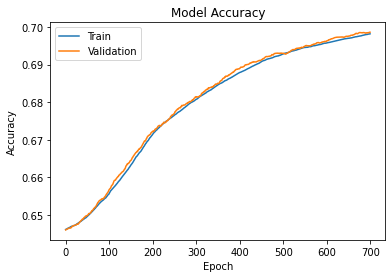

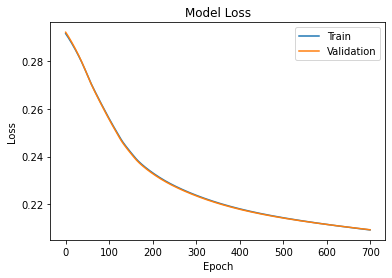

In [9]:


# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

